## Model Explanation for Classification Models

This document describes the usage of a classification model to provide an explanation for a given prediction.

Model explanation provides the ability to interpret the effect of the predictors on the composition of an individual score. These predictors can then be ranked according to their contribution in the final score (leading to a positive or negative decision).

Model explanation has always been used in credit risk applications in presence of [regulatory settings](https://en.wikipedia.org/wiki/Credit_score) . The credit company is expected to give the customer the main (top n) reasons why the credit application was rejected (also known as _reason codes_).

Model explanation was also recently introduced by the  European Union’s new General Data Protection Regulation (GDPR, https://arxiv.org/pdf/1606.08813.pdf) to add the possibility to control the increasing use of machine learning algorithms in routine decision-making processes. 
> The law will also effectively create a “right to explanation,” whereby a user can ask for an explanation of an algorithmic decision that was made about them. 




## Sample scikit-learn Classification Model 

Here, we will use a sciki-learn classification model on a standard dataset (breast cancer detection model).

The dataset used contains 30 predictor variables (numerical features) and one binary target (dependant variable). For practical reasons, we will restrict our study to the first 4 predictors in this document.


In [1]:
from sklearn import datasets
import pandas as pd

ds = datasets.load_breast_cancer();
NC = 4
lFeatures = ds.feature_names[0:NC]

df = pd.DataFrame(ds.data[:,0:NC] , columns=lFeatures)
df['TGT'] = ds.target
df.sample(6, random_state=1960)

,mean radius,mean texture,mean perimeter,mean area,TGT
50,11.76,21.60,74.72,427.9,1
457,13.21,25.25,84.10,537.9,1
259,15.53,33.56,103.70,744.9,0
85,18.46,18.52,121.10,1075.0,0
348,11.47,16.03,73.02,402.7,1
462,14.40,26.99,92.25,646.1,1


For the classification task, we will build a ridge regression model, and train it on a part of the full dataset

In [2]:
from sklearn.linear_model import *
clf = RidgeClassifier(random_state = 1960)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[lFeatures].values, df['TGT'].values, test_size=0.2, random_state=1960)
clf.fit(X_train , y_train)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=1960, solver='auto',
        tol=0.001)

This is a standard linear model, that assigns a coefficient to each predictor value, these coefficients can be seen as global importance indicators for the predictors.

,variable,importance
0,mean radius,0.485304
1,mean area,0.001594
2,mean texture,-0.032116
3,mean perimeter,-0.120404


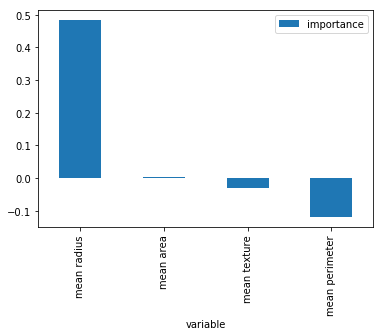

In [3]:
coefficients = dict(zip(ds.feature_names, [clf.coef_.ravel()[i] for i in range(clf.coef_.shape[1])]))
df_var_importance = pd.DataFrame()
df_var_importance['variable'] = coefficients.keys()
df_var_importance['importance'] = df_var_importance['variable'].apply(coefficients.get)
%matplotlib inline
df_var_importance.plot('variable' , ['importance'], kind='bar')
df_var_importance.head()


To put it simply, this is a global view of all the indivduals. The most important variable is 'mean radius', the higher the radius of the tumor, the higher the score of being malignant. On the oppopsite side, the higher the 'mean perimeter' is, the lower the score.

## Model Explanation

The goal here is to be able, for a given individual, the impact of each predictor on the final score.

For our model, the score is a linear combination of predictor values:

$$ Score = \alpha_1 X_1 + \alpha_2 X_2 + \alpha_3 X_3 + \alpha_4 X_4 + \beta $$

One can see $\alpha_1 X_1$ as the contribution of the predictor $X_1$, $\alpha_2 X_2$ as the contribution of the predictor $X_2$, etc

These contributions can be seen as _partial scores_ and their sum is the final score (used to assign positive or negative decision).

The intercept $\beta$ being constant, it can be ignored when analyzing individual effects.

In scikit-learn , the score is computed by a decision_function method of the classifier, an individual is detected as positive if the score has a positive value.


In [4]:
df['Score'] = clf.decision_function(df[lFeatures].values)
df['Decision'] = clf.predict(df[lFeatures].values)
df.sample(6, random_state=1960)

,mean radius,mean texture,mean perimeter,mean area,TGT,Score,Decision
50,11.76,21.60,74.72,427.9,1,0.774029,1
457,13.21,25.25,84.10,537.9,1,0.406407,1
259,15.53,33.56,103.70,744.9,0,-0.764609,0
85,18.46,18.52,121.10,1075.0,0,-0.428609,0
348,11.47,16.03,73.02,402.7,1,0.976705,1
462,14.40,26.99,92.25,646.1,1,0.119175,1


### Predictor Effects

Predictor effects describe the impact of specific predictor values on the partial score. For example, some values of a predictor can increase or decrease  the partial score (and hence the score) by 10 or more points and change the negative decision to a positive one.

The effect reflects how a specific predictor increases the score (above the mean contribtution of this variable). 


In [5]:
for col in lFeatures:
    lContrib = df[col] * coefficients[col]
    df[col + '_Effect'] = lContrib - lContrib.mean()
df.sample(6, random_state=1960)

,mean radius,mean texture,mean perimeter,mean area,TGT,Score,Decision,mean radius_Effect,mean texture_Effect,mean perimeter_Effect,mean area_Effect
50,11.76,21.60,74.72,427.9,1,0.774029,1,-1.148856,-0.074200,2.076852,-0.361738
457,13.21,25.25,84.10,537.9,1,0.406407,1,-0.445165,-0.191424,0.947463,-0.186438
259,15.53,33.56,103.70,744.9,0,-0.764609,0,0.680740,-0.458310,-1.412455,0.143445
85,18.46,18.52,121.10,1075.0,0,-0.428609,0,2.102681,0.024718,-3.507484,0.669504
348,11.47,16.03,73.02,402.7,1,0.976705,1,-1.289595,0.104688,2.281539,-0.401898
462,14.40,26.99,92.25,646.1,1,0.119175,1,0.132346,-0.247306,-0.033829,-0.014007


The previous sample, shows that the first individual lost 1.148856 score points due to the feature $X_1$, gained 2.076852 with the feature $X_3$, etc

## Reason Codes

The reason codes are a user-oriented representation of the decision making process. These are the predictors ranked by their effects. 


In [6]:
import numpy as np
reason_codes = np.argsort(df[[col + '_Effect' for col in lFeatures]].values, axis=1)
df_rc = pd.DataFrame(reason_codes, columns=['reason_' + str(NC-c) for c in range(NC)])
df_rc = df_rc[list(reversed(df_rc.columns))]
df = pd.concat([df , df_rc] , axis=1)
for c in range(NC):
    df['reason_' + str(c+1)] = df['reason_' + str(c+1)].apply(lambda x : lFeatures[x])
df.sample(6, random_state=1960)

,mean radius,mean texture,mean perimeter,mean area,TGT,Score,Decision,mean radius_Effect,mean texture_Effect,mean perimeter_Effect,mean area_Effect,reason_1,reason_2,reason_3,reason_4
50,11.76,21.60,74.72,427.9,1,0.774029,1,-1.148856,-0.074200,2.076852,-0.361738,mean perimeter,mean texture,mean area,mean radius
457,13.21,25.25,84.10,537.9,1,0.406407,1,-0.445165,-0.191424,0.947463,-0.186438,mean perimeter,mean area,mean texture,mean radius
259,15.53,33.56,103.70,744.9,0,-0.764609,0,0.680740,-0.458310,-1.412455,0.143445,mean radius,mean area,mean texture,mean perimeter
85,18.46,18.52,121.10,1075.0,0,-0.428609,0,2.102681,0.024718,-3.507484,0.669504,mean radius,mean area,mean texture,mean perimeter
348,11.47,16.03,73.02,402.7,1,0.976705,1,-1.289595,0.104688,2.281539,-0.401898,mean perimeter,mean texture,mean area,mean radius
462,14.40,26.99,92.25,646.1,1,0.119175,1,0.132346,-0.247306,-0.033829,-0.014007,mean radius,mean area,mean perimeter,mean texture


In [7]:
df[['reason_' + str(NC-c) for c in range(NC)]].describe()

,reason_4,reason_3,reason_2,reason_1
count,569,569,569,569
unique,4,4,4,3
top,mean radius,mean area,mean texture,mean perimeter
freq,331,350,355,343


## Going Further

This was an introductory document with a simple linear classifier. Deeper analysis can be made to extend this study

* Non-linear models (generalizing contributions, non-parameteric setting ?)
* Other classifiers (SVMs, Decision Trees, Naive Bayes, MLP, Ensembles, etc)
* Other predictors (categorical features, ordered, ...)
* More risk scoring (https://kdd11pmml.files.wordpress.com/2011/09/p2_flint_guazzelli_kdd_20112.pdf)
